# Gaussian Process Latent Variable Model

Open processed video sample using OpenCV library:

In [1]:
import numpy as np
import cv2

w,h = 120,90

sample = np.load('data\samplevideo.npy')
print(sample[0,:])

[ 116.  121.  130. ...,  109.   67.   65.]


Function for displaying one frame:

In [2]:
def show_frame(frame):
    
    mp.imshow(frame.reshape((h,w)),cmap='Greys_r')

Plot the first frame of sample:

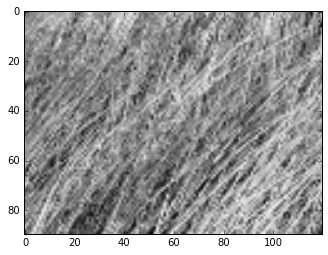

In [3]:
import matplotlib.pyplot as mp

% matplotlib inline
show_frame(sample[0,:])

Initialize all the parameters and normilize given sample:

In [4]:
sample_max = sample[:,:].max()
sample_min = sample[:,:].min()
print(sample_min, sample_max)

27.0 233.0


In [5]:
N = sample.shape[0] # count of samples
D = sample.shape[1] # dimensionality of observed space
Q = 20 # dimensionality of observed space

X = np.zeros((N,Q)) # Initialize the latent variable

#normilizing data:
sample_mean = np.mean(sample)
sample_std = np.std(sample)
sample_norm = (sample - sample_mean)/sample_std # normalization

print(sample_norm)
print(sample_mean)
print(sample_std)

[[-0.25717991 -0.05194427  0.31747988 ..., -0.54450981 -2.26848918
  -2.35058344]
 [ 0.39957413  0.03014998  0.23538562 ...,  0.56376265 -1.73487652
   1.05632818]
 [ 0.9331868   0.11224424  0.52271552 ...,  1.05632818 -0.3803213
   3.76543863]
 ..., 
 [-1.07812247  0.97423393 -0.25717991 ...,  0.03014998 -1.65278226
   0.9331868 ]
 [ 1.79517648  0.52271552 -0.62660407 ..., -0.29822704  0.76899829
  -0.25717991]
 [ 0.19433849  2.49297766 -0.29822704 ...,  0.85109254  0.15329137
  -0.74974545]]
122.265478889
24.3622404217


In [6]:
np.mean(sample_norm)

-1.6720386392316195e-16

Define combined kernel using GPy library:

In [7]:
import GPy

kernel = GPy.kern.Linear(Q,ARD=True)+GPy.kern.RatQuad(Q,ARD=True)+GPy.kern.MLP(Q,ARD=True)
#kernel = GPy.kern.Linear(Q,ARD=True)+GPy.kern.RBF(Q,ARD=True)+GPy.kern.RatQuad(Q,ARD=True)+GPy.kern.MLP(Q,ARD=True)+GPy.kern.Matern52(Q,ARD=True)
#kernel = GPy.kern.RBF(Q,ARD=True)
m = GPy.models.GPLVM(sample_norm, input_dim=Q, kernel=kernel, init='PCA')

Optimization of the model using SCG (Warning! Minimum value for max_iters is 100, for 10000 it takes around 1 hour to perform optimization)

In [8]:
m.optimize(messages=True, optimizer = 'SCG',max_iters=1000)

Extract latent X from the model:

In [9]:
X = m.X
print(X)

  index      |  GPLVM.latent_mean  |  constraints  |  priors
  [0 0]      |        -2.16588707  |               |        
  [0 1]      |         1.52202085  |               |        
  [0 2]      |        -0.13321674  |               |        
  [0 3]      |         0.01840710  |               |        
  [0 4]      |        -0.01132363  |               |        
  [0 5]      |        -4.20895838  |               |        
  [0 6]      |         1.95118927  |               |        
  [0 7]      |        -0.20923258  |               |        
  [0 8]      |         1.17822472  |               |        
  [0 9]      |        -0.88834909  |               |        
  [ 0 10]    |        -1.73407407  |               |        
  [ 0 11]    |         0.64127265  |               |        
  [ 0 12]    |         0.70398188  |               |        
  [ 0 13]    |         1.51886327  |               |        
  [ 0 14]    |        -1.32007880  |               |        
  [ 0 15]    |         4

Plot first 5 values to visualize:

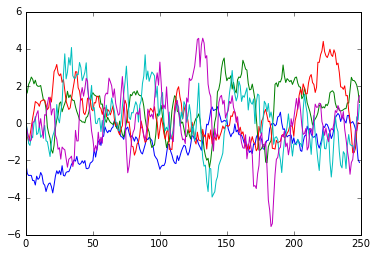

In [10]:
mp.plot(X[:,0:5])

Extract kernel matrix:

In [11]:
Kx = kernel.K(X[0:N-1])
print(Kx)

[[ 0.90218639  0.59403696  0.4598292  ...,  0.27427643  0.34397485
   0.35769028]
 [ 0.59403696  0.90731881  0.61251671 ...,  0.2653696   0.3258724
   0.34146508]
 [ 0.4598292   0.61251671  0.91370488 ...,  0.26281996  0.32278741
   0.33064697]
 ..., 
 [ 0.27427643  0.2653696   0.26281996 ...,  0.85109636  0.4286385
   0.31010494]
 [ 0.34397485  0.3258724   0.32278741 ...,  0.4286385   0.85372951
   0.46825325]
 [ 0.35769028  0.34146508  0.33064697 ...,  0.31010494  0.46825325
   0.87669072]]


Function to predict new artificial frame using mean prediction method:

In [12]:
def predict_new_latent_frame(N,X,kern,Kx_inv,X_old):
    
    k_x = kern.K(X[0:N-1],X_old)
    #k_xx = kern.K(X_old,X_old)

    meann = np.matmul(np.matmul(np.transpose(X[1:N]),Kx_inv),k_x).flatten()
    #cov = (k_xx - np.matmul(np.matmul(np.transpose(k_x),Kx_inv),k_x)) * np.eye(Q)
    
    #R = np.random.multivariate_normal(meann,cov)
    R = meann
    
    return R

Perform prediciton of new X:

In [13]:
N_synt = 250  #for evaluation - the same number as in the input
X_synt = np.zeros((N_synt,Q))
X_last = X[N-1:N]
Kx_inv = np.linalg.inv(Kx)

for i in range(N_synt):
    X_synt[i,:] = predict_new_latent_frame(N,X,kernel,Kx_inv,X_last.reshape(1,Q))
    X_last = X_synt[i,:]
    
print(X_synt)

[[ -1.90250567e+00   9.60123069e-01   2.72868120e-01 ...,   6.07145616e-01
   -1.76056464e-01  -8.69366309e-01]
 [ -2.06305692e+00   1.11730387e+00   2.27465440e-01 ...,   1.00698449e+00
    9.66046804e-02  -9.22675061e-01]
 [ -2.30474288e+00   1.29006356e+00   1.14514720e-01 ...,   1.03937684e+00
    8.19900944e-01  -9.23068624e-01]
 ..., 
 [ -2.55714883e+00   1.43185545e+00   2.03697489e-02 ...,   8.98482055e-01
    1.63288439e+00  -8.86496415e-01]
 [ -2.78337359e+00   1.51339121e+00   1.62187008e-03 ...,   7.21021008e-01
    2.15229740e+00  -8.09859419e-01]
 [ -2.97590227e+00   1.50552810e+00   6.24883697e-02 ...,   5.09402307e-01
    2.10968930e+00  -8.12850635e-01]]


Plot of new X:

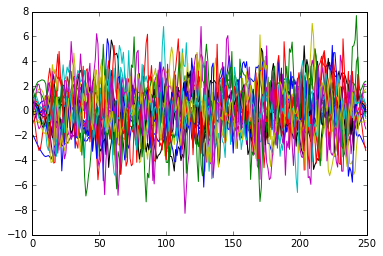

In [14]:
mp.plot(X_synt)

Now perform syntesis of new dinamic texture by mean prediction

In [15]:
Y_synt = np.zeros((N_synt,D))

Ky = kernel.K(X)
Ky_inv = np.linalg.inv(Ky)
Y_t = np.transpose(sample_norm)
k_y = kernel.K(X,X_synt)

meann = np.matmul(np.matmul(Y_t,Ky_inv),k_y)

Y_synt = np.transpose(meann)
    
print(Y_synt)

[[ 0.65798974  1.59354015  0.37039953 ..., -0.20296628 -0.39027027
  -0.78459231]
 [ 0.97554185  1.11309232  0.54361594 ..., -0.40224429 -0.43359882
  -0.71849771]
 [ 1.2426876   0.73038595  0.59099222 ..., -0.45115585 -0.44293881
  -0.60679482]
 ..., 
 [ 1.46686249  0.46309823  0.55451614 ..., -0.6004757  -0.56460722
  -0.4055201 ]
 [ 1.59403717  0.36586969  0.4911893  ..., -0.83564997 -0.80120025
  -0.17519368]
 [ 1.61419874  0.41463056  0.49146537 ..., -1.01478805 -0.99730535
  -0.01810198]]


Display first frame:

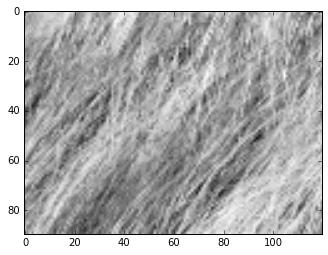

In [16]:
show_frame(Y_synt[0,:])

Denormalization:

In [17]:
Y_synt_denorm = sample_std * Y_synt + sample_mean
max = Y_synt_denorm[:,:].max()
min = Y_synt_denorm[:,:].min()
print(min, max)
print(sample_min,sample_max)

27.0469839255 233.0
27.0 233.0


In [18]:
sample_mean2 = np.mean(Y_synt_denorm)
sample_std2 = np.std(Y_synt_denorm)

print(sample_mean,sample_std)
print(sample_mean2,sample_std2)

122.265478889 24.3622404217
122.224519598 23.9130427643


Now we can compute Mean Sqare Error:

In [19]:
(((sample[100,:] - Y_synt_denorm[100,:])**2).sum()/D)**(1/2)

29.642529000095614

[ 0.79538627  0.81087218  0.81594769  0.87120661  0.80664055  0.80571574
  0.76681285  0.83441992  0.80084132  0.76321822  0.81078876  0.94764673
  1.0478442   1.21886123  1.25427833  1.35083404  1.41700909  1.48744167
  1.40389382  1.42185729  1.52341666  1.42695378  1.37555245  1.43901799
  1.4057281   1.34119161  1.3852212   1.25475412  1.2881962   1.24019375
  1.32949785  1.36566233  1.33642193  1.27985752  1.31920874  1.41354676
  1.42865336  1.39980386  1.36261112  1.27463155  1.25072481  1.22457986
  1.23339319  1.26371357  1.27109401  1.32938401  1.30104115  1.36509594
  1.28599791  1.27240818  1.28538012  1.34829641  1.32944228  1.3840324
  1.45327807  1.46954531  1.54025762  1.46400802  1.41634266  1.50841746
  1.41042715  1.49684531  1.48913731  1.37839326  1.37443057  1.43583272
  1.50998925  1.44935189  1.49937505  1.42302597  1.38513181  1.44921598
  1.49547066  1.4495359   1.36962954  1.4169772   1.42552537  1.41376625
  1.36852008  1.3255308   1.33407382  1.43305655  1.

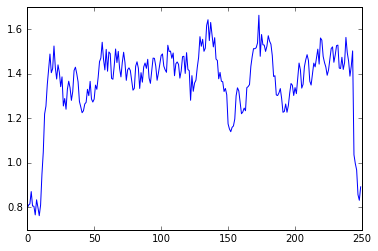

In [20]:
MSE_norm = (1/D)*((sample_norm - Y_synt)**2).sum(1)
print(MSE_norm)
mp.plot(MSE_norm)

In [21]:
(((sample_norm[100,:] - Y_synt[100,:])**2).sum()/D)**(1/2)

1.2167406809447705

[ 472.07666915  481.26785004  484.28025829  517.0774655   478.75630008
  478.20740713  455.11781194  495.2438724   475.31434336  452.98432806
  481.21833663  562.44610938  621.91519005  723.4170042   744.43771857
  801.74534242  841.02147352  882.8245332   833.2373176   843.8989741
  904.17636197  846.92383321  816.41617999  854.08416826  834.32599536
  796.02237849  822.15476541  744.72010724  764.56861057  736.07825711
  789.08191104  810.54620871  793.191483    759.61944892  782.97513441
  838.96651759  847.93256758  830.80985041  808.73525785  756.51773744
  742.32863573  726.81112049  732.04199691  750.03771024  754.41813854
  789.01434794  772.19233015  810.21004988  763.26388352  755.19812564
  762.89721201  800.23921066  789.04893005  821.44919297  862.5477961
  872.20270963  914.17178833  868.91621973  840.62593682  895.27405817
  837.11497089  888.40576723  883.83092575  818.10225758  815.75032487
  852.19365041  896.20694484  860.21753288  889.90721776  844.59260415
  822.10

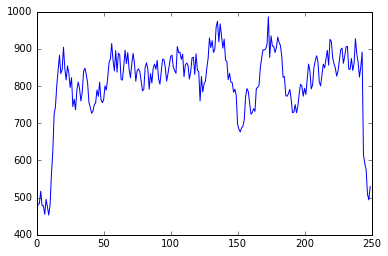

In [22]:
MSE = (1/D)*((sample - Y_synt_denorm)**2).sum(1)
print(MSE)
mp.plot(MSE)

Finally, save synthesized video:

In [23]:
cap = cv2.VideoCapture(0)
fourcc = cv2.VideoWriter_fourcc(*'DIB ')
#fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('data\out_eval.avi',fourcc, 25.0, (w,h))

for i in range(N_synt):
    print(i)
    frame = Y_synt_denorm[i,:].reshape((h,w)).astype(int)
    max = frame.max()
    min = frame.min()
    frame = (255/(max - min))*(frame - min)    
    img = np.zeros((90,120,3), np.uint8)
    img[:,:,0] = frame
    img[:,:,1] = frame
    img[:,:,2] = frame
    out.write(img)

cap.release()
out.release()
cv2.destroyAllWindows()
print('Done!')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
Done!
